In [13]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)
import xgboost as xgb
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

In [2]:
print(xgb.__version__)

3.1.3


In [ ]:
data = pd.read_csv('./data/ai4i2020_processed.csv')

features = data.drop(columns=['Machine_failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])
#labels = data[["TWF", 'HDF', 'PWF', 'OSF', 'RNF']]
labels = data['Machine_failure']

features = features.astype(np.float64)
labels = labels.astype(np.float64)  

print(features.head())
print(labels.head())
print(features.__len__())

   Air temperature _K_  Process temperature _K_  Rotational speed _rpm_  \
0            -0.952342                -0.947313                0.068182   
1            -0.902348                -0.879915               -0.729435   
2            -0.952342                -1.014710               -0.227438   
3            -0.902348                -0.947313               -0.589992   
4            -0.902348                -0.879915               -0.729435   

   Torque _Nm_  Tool wear _min_  delta_temp     power  Type_H  Type_L  Type_M  
0     0.282186         0.000000    0.498824  0.629412     0.0     0.0     1.0  
1     0.633276         0.011858    0.498824  0.512431     0.0     1.0     0.0  
2     0.944242         0.019763    0.398934  1.376820     0.0     1.0     0.0  
3    -0.048843         0.027668    0.398934 -0.329993     0.0     1.0     0.0  
4     0.001313         0.035573    0.498824 -0.357806     0.0     1.0     0.0  
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Machine failure, d

In [4]:
features = features.copy()
features.columns = features.columns.astype(str)
features.columns = (
    features.columns
    .str.replace('[', '_', regex=False)
    .str.replace(']', '_', regex=False)
)
print(features.head())
print(labels.head())
print(features.__len__())

   Air temperature _K_  Process temperature _K_  Rotational speed _rpm_  \
0            -0.952342                -0.947313                0.068182   
1            -0.902348                -0.879915               -0.729435   
2            -0.952342                -1.014710               -0.227438   
3            -0.902348                -0.947313               -0.589992   
4            -0.902348                -0.879915               -0.729435   

   Torque _Nm_  Tool wear _min_  delta_temp     power  Type_H  Type_L  Type_M  
0     0.282186         0.000000    0.498824  0.629412     0.0     0.0     1.0  
1     0.633276         0.011858    0.498824  0.512431     0.0     1.0     0.0  
2     0.944242         0.019763    0.398934  1.376820     0.0     1.0     0.0  
3    -0.048843         0.027668    0.398934 -0.329993     0.0     1.0     0.0  
4     0.001313         0.035573    0.498824 -0.357806     0.0     1.0     0.0  
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Machine failure, d

Accuracy: 0.9838
AUC: 0.9783872401979817
Confusion Matrix:
 [[4794   37]
 [  44  125]]
Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      4831
         1.0       0.77      0.74      0.76       169

    accuracy                           0.98      5000
   macro avg       0.88      0.87      0.87      5000
weighted avg       0.98      0.98      0.98      5000



<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

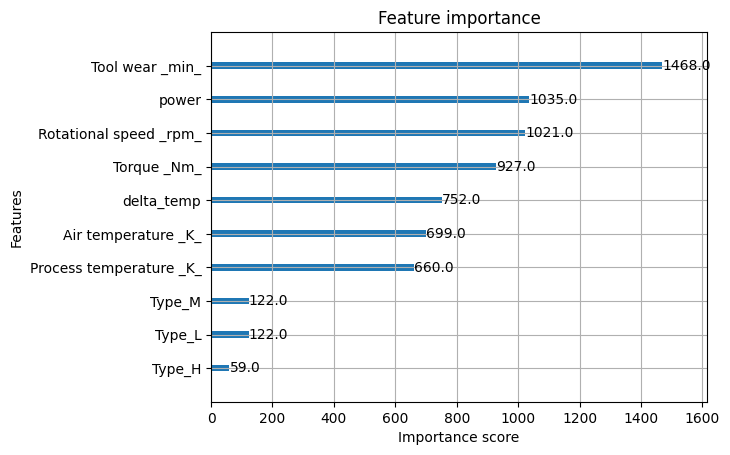

In [5]:

X_train, X_test, y_train, y_test = train_test_split(
    features, labels,
    test_size=0.5,
    random_state=42,
    stratify=labels
)

model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    scale_pos_weight = (labels == 0).sum() / (labels == 1).sum(),
    objective='binary:logistic', # 学习目标函数
    eval_metric='auc', # 评估指标
    n_jobs=-1
)


model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

#y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Report:\n", classification_report(y_test, y_pred))

xgb.plot_importance(model)


Accuracy: 0.98
AUC: 0.9635494946129691
Confusion Matrix:
 [[6685   78]
 [  62  175]]
Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      6763
         1.0       0.69      0.74      0.71       237

    accuracy                           0.98      7000
   macro avg       0.84      0.86      0.85      7000
weighted avg       0.98      0.98      0.98      7000



<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

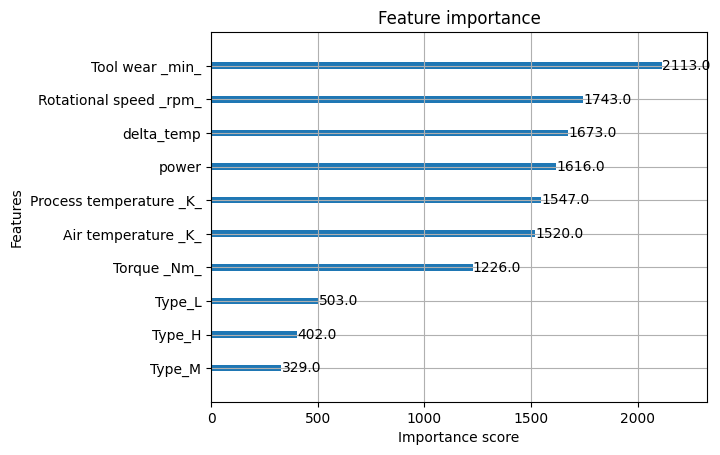

In [32]:


X_train, X_test, y_train, y_test = train_test_split(
    features, labels,
    test_size=0.7,
    random_state=42,
    stratify=labels
)

smote = SMOTE(random_state=42, k_neighbors=5)
X_train, y_train = smote.fit_resample(X_train, y_train)

model = XGBClassifier(
    n_estimators=300,
    max_depth=10,
    learning_rate=0.05,
    scale_pos_weight = (labels == 0).sum() / (labels == 1).sum(),
    objective='binary:logistic', 
    eval_metric='aucpr', 
    subsample=0.5,
    device='cuda',
)

eval_set = [(X_train, y_train), (X_test, y_test)]

model.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    verbose=False,
)

threshold = 0.95
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
y_pred = (y_prob>=threshold).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Report:\n", classification_report(y_test, y_pred))

xgb.plot_importance(model)

In [33]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

f1 = 2 * precision * recall / (precision + recall + 1e-8)
best_idx = f1.argmax()

print("Best threshold:", thresholds[best_idx])
print("Precision:", precision[best_idx])
print("Recall:", recall[best_idx])
print("F1:", f1[best_idx])


Best threshold: 0.9638543
Precision: 0.729957805907173
Recall: 0.729957805907173
F1: 0.729957800907173


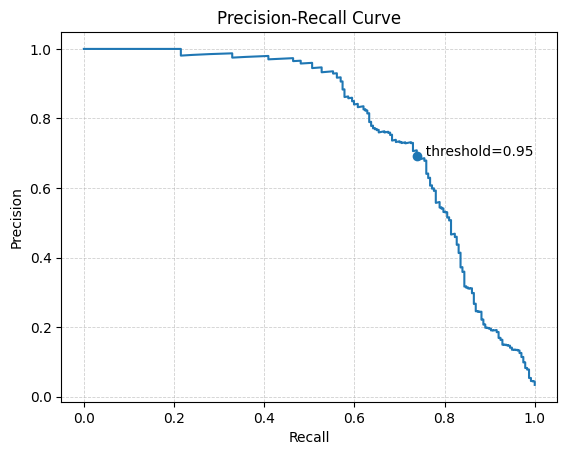

In [34]:

precision, recall, thresholds = precision_recall_curve(y_test, y_prob, )
idx = (y_prob >= threshold)
p = (y_test[idx] == 1).sum() / idx.sum()
r = (y_test[idx] == 1).sum() / (y_test == 1).sum()
plt.plot(recall, precision)
plt.scatter(r, p)
plt.text(r, p, f"  threshold={threshold}", fontsize=10)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True, alpha=0.6, linestyle='--', linewidth=0.6)


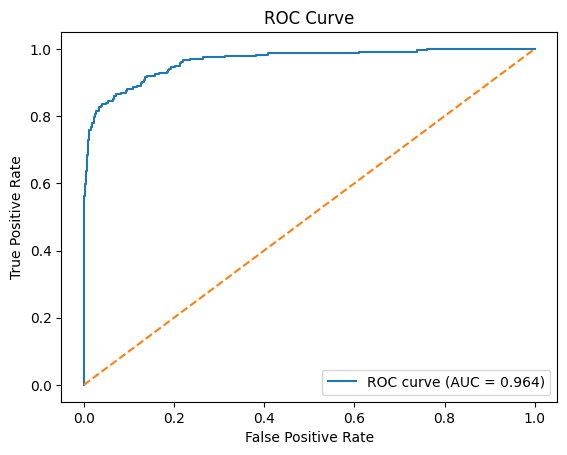

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()
